In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler,random_split, ConcatDataset, Subset
from torch import nn, optim
from torch.cuda import amp
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler
import torch.optim.lr_scheduler as lr_scheduler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check if the GPU is available
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:30<00:00, 81.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [4]:
# Paths for train, test, and val directories
path = path + '/chest_xray'
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")
val_dir = os.path.join(path, "val")

train_dir, test_dir, val_dir

('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train',
 '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test',
 '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')

In [5]:
def concat_data(data_path):
  filepaths = []
  labels = []

  folds = os.listdir(data_path)
  for file in folds:
      foldpath = os.path.join(data_path, file)
      filelist = os.listdir(foldpath)

      for f in filelist:
          fpath = os.path.join(foldpath, f)
          filepaths.append(fpath)
          labels.append(file)

  FSeries = pd.Series(filepaths, name='filepaths')
  LSeries = pd.Series(labels, name='label')

  df = pd.concat([FSeries, LSeries], axis=1)
  return df

train_df = concat_data(train_dir)
test_df = concat_data(test_dir)
valid_df = concat_data(val_dir)

In [6]:
# Combine all data
all_data_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
print(all_data_df['label'].value_counts())

all_data_df

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64


,filepaths,label
0,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
1,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
2,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
3,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
4,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
...,...,...
5851,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5852,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5853,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5854,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA


In [8]:
# load augmented data for NORMAL class
# Set up directories
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

normal_aug_df = concat_data('/content/drive/MyDrive/augmented_normal_images_2/')
normal_aug_df

Mounted at /content/drive


,filepaths,label
0,/content/drive/MyDrive/augmented_normal_images...,NORMAL
1,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2,/content/drive/MyDrive/augmented_normal_images...,NORMAL
3,/content/drive/MyDrive/augmented_normal_images...,NORMAL
4,/content/drive/MyDrive/augmented_normal_images...,NORMAL
...,...,...
2685,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2686,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2687,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2688,/content/drive/MyDrive/augmented_normal_images...,NORMAL


In [9]:
# Combine all data
all_data_df = pd.concat([train_df, test_df, valid_df, normal_aug_df], ignore_index=True)
print(all_data_df['label'].value_counts())

all_data_df

label
NORMAL       4273
PNEUMONIA    4273
Name: count, dtype: int64


,filepaths,label
0,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
1,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
2,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
3,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
4,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
...,...,...
8541,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8542,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8543,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8544,/content/drive/MyDrive/augmented_normal_images...,NORMAL


In [10]:
# Split into training (70%) and remaining (30%) for validation and test
train_df, remaining_df = train_test_split(all_data_df, test_size=0.3, stratify=all_data_df['label'], random_state=42)

# Split remaining data into validation (50% of remaining) and test (50% of remaining)
valid_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['label'], random_state=42)

print(f"Train label distribution:\n{train_df['label'].value_counts()}")
print(f"Validation label distribution:\n{valid_df['label'].value_counts()}")
print(f"Test label distribution:\n{test_df['label'].value_counts()}")

Train label distribution:
label
NORMAL       2991
PNEUMONIA    2991
Name: count, dtype: int64
Validation label distribution:
label
NORMAL       641
PNEUMONIA    641
Name: count, dtype: int64
Test label distribution:
label
PNEUMONIA    641
NORMAL       641
Name: count, dtype: int64


In [11]:
batch_size = 32
img_size = (64, 64)

data_gen = ImageDataGenerator(
    rescale=1./255
)

train_gen = data_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = data_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

test_gen = data_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

# Validation Set Too Small
# A validation set with 16 images cannot generalize the model's performance properly. Fluctuations in accuracy and loss will occur due to random chance.

Found 5982 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.


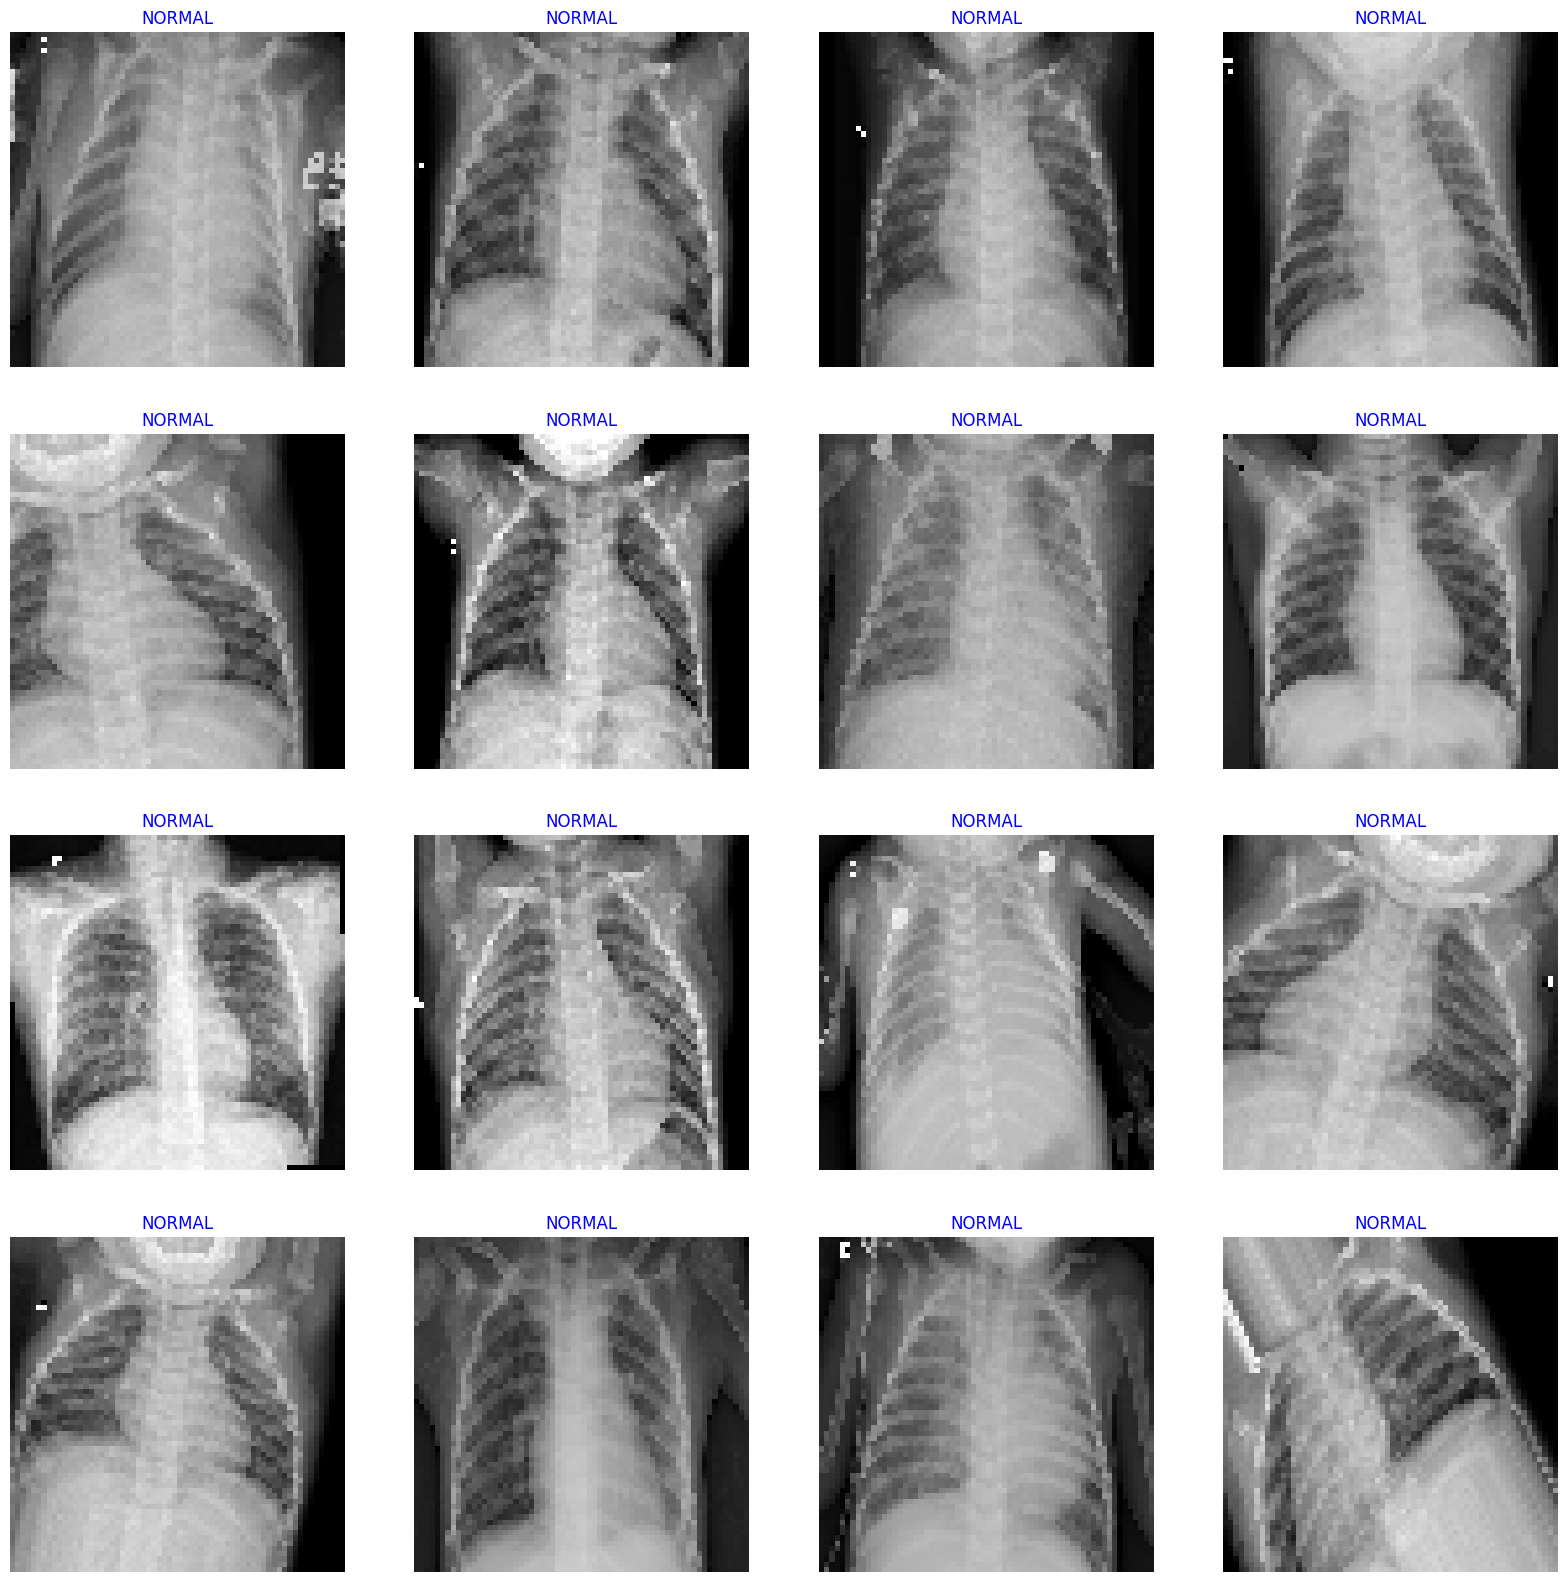

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(64, 64, 3)):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,538,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 5,772,641 (22.02 MB)

 Trainable params: 5,772,641 (22.02 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs = 5

from datetime import datetime
print('start', datetime.now())
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)
print('end', datetime.now())

start 2024-12-18 12:28:54.591233
Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 161s 780ms/step - accuracy: 0.5654 - loss: 0.6724 - val_accuracy: 0.9033 - val_loss: 0.2648
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 433ms/step - accuracy: 0.8740 - loss: 0.3033 - val_accuracy: 0.9314 - val_loss: 0.1909
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 394ms/step - accuracy: 0.9297 - loss: 0.2004 - val_accuracy: 0.9548 - val_loss: 0.1227
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 390ms/step - accuracy: 0.9475 - loss: 0.1487 - val_accuracy: 0.9555 - val_loss: 0.1505
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 393ms/step - accuracy: 0.9533 - loss: 0.1329 - val_accuracy: 0.9594 - val_loss: 0.1058
end 2024-12-18 12:36:41.926356


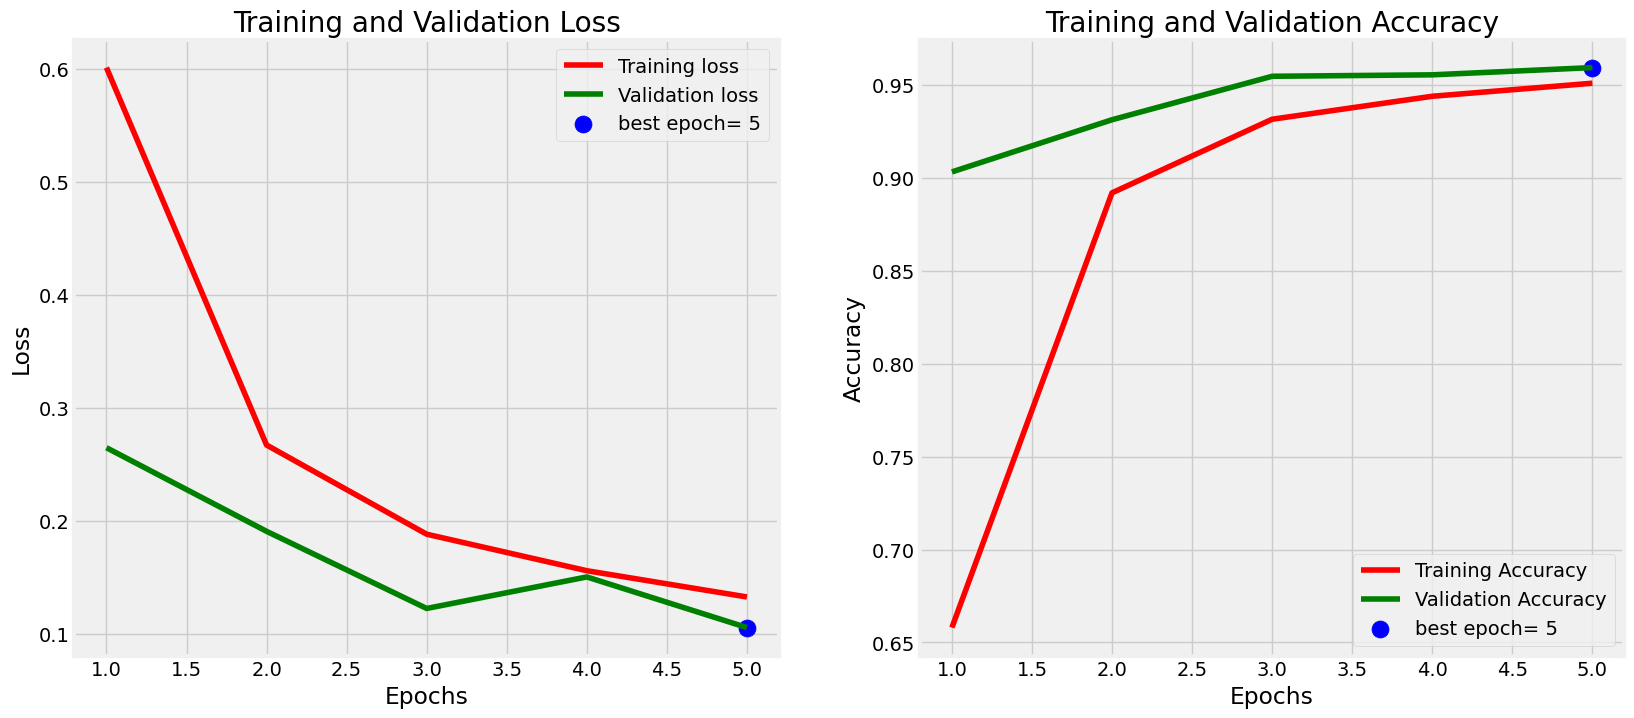

In [15]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

187/187 ━━━━━━━━━━━━━━━━━━━━ 60s 323ms/step - accuracy: 0.9728 - loss: 0.0783
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.9461 - loss: 0.1366
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - accuracy: 0.9606 - loss: 0.1034
Train Loss:  0.0750984400510788
Train Accuracy:  0.9749248027801514
--------------------
Validation Loss:  0.105766162276268
Validation Accuracy:  0.9594383835792542
--------------------
Test Loss:  0.11349193006753922
Test Accuracy:  0.9563182592391968


In [17]:
preds = model.predict(test_gen)
y_pred = (preds > 0.5).astype(int)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step


array([[608,  33],
       [ 23, 618]])

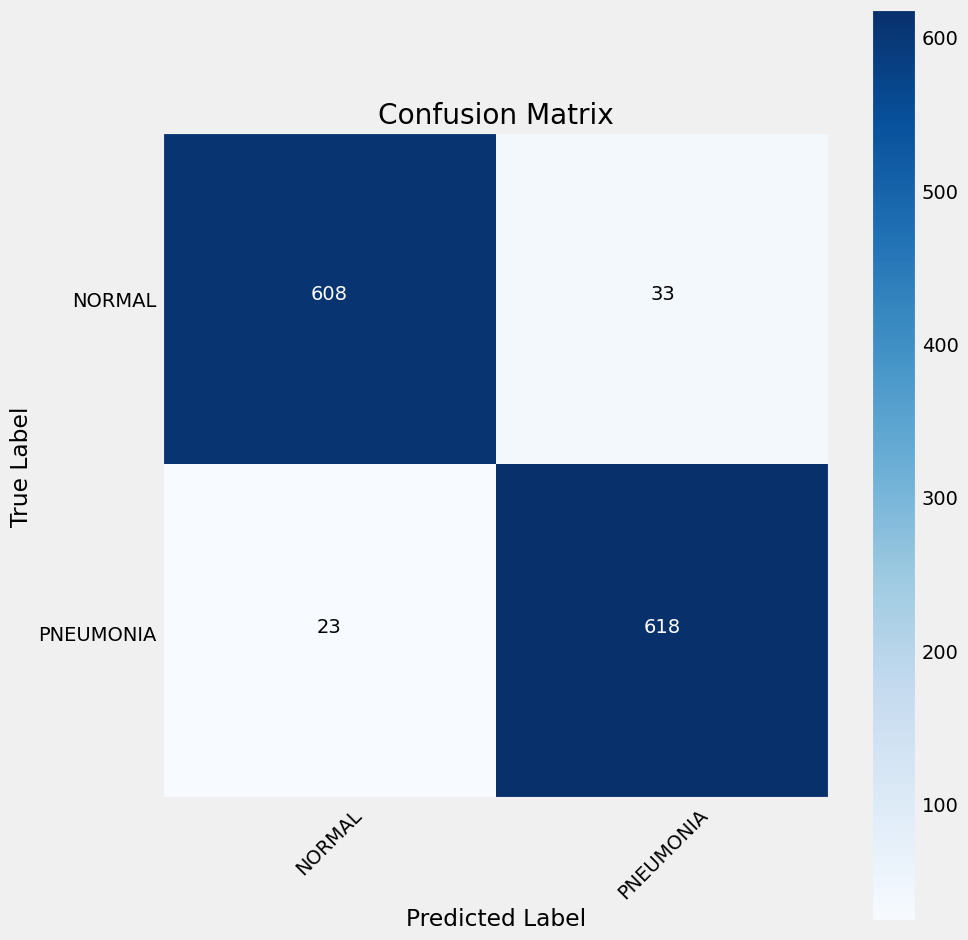

In [20]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.grid(False)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.96      0.95      0.96       641
   PNEUMONIA       0.95      0.96      0.96       641

    accuracy                           0.96      1282
   macro avg       0.96      0.96      0.96      1282
weighted avg       0.96      0.96      0.96      1282



In [22]:
model.save('/content/drive/MyDrive/modelsaved/cnnPaper_model.h5')
